#### Introduction
Strava is a social media for runners. I downloaded my running data below and want to do some predictions. For example, currently I don't have a runner's watch. Which means it only has the most basic functionality of timing. However, this way I wouldn't know the distance I have ran then. So, I ran regression models to predict the distance I ran (km) based on the elapsed time (seconds).

In [2]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_curve, roc_auc_score
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df_raw = pd.read_csv("src/activities.csv")
df_raw.head()

,Activity ID,Activity Date,Activity Name,Activity Type,City,Country,Activity Description,Elapsed Time,Distance,Max Heart Rate,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>",Media
0,4568671345,"Jan 5, 2021, 12:08:49 AM",Afternoon run,Run,San Francisco,United States,Ferry pier to aquatic cove,1942,4.30,NaN,...,NaN,NaN,1.0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
1,4589644717,"Jan 9, 2021, 1:48:33 AM",Evening run,Run,San Francisco,United States,Ferry pier to Oracle Park,2059,5.04,NaN,...,NaN,NaN,NaN,NaN,91.300003,NaN,NaN,NaN,NaN,NaN
2,9274196948,"Jun 16, 2023, 3:11:21 AM",Lunch run,Run,Tokyo,Japan,From Tsukishima to Harumi,2483,6.18,NaN,...,NaN,NaN,0.0,2.489017,0.000000,NaN,NaN,NaN,5562.0,NaN
3,9288341297,"Jun 18, 2023, 9:38:28 AM",Evening Run,Run,Tokyo,Japan,Tokyo Imperial Palace,3731,10.09,NaN,...,NaN,NaN,0.0,2.705135,0.000000,NaN,NaN,NaN,9256.0,NaN
4,9299786348,"Jun 20, 2023, 8:53:49 AM",Progression run,Run,Tokyo,Japan,Tokyo Imperial Palace,1800,5.78,NaN,...,NaN,NaN,0.0,3.212461,0.000000,NaN,NaN,NaN,4834.0,NaN


In [7]:
df = df_raw[['Elapsed Time', 'Distance']]
df.head()

,Elapsed Time,Distance
0,1942,4.30
1,2059,5.04
2,2483,6.18
3,3731,10.09
4,1800,5.78


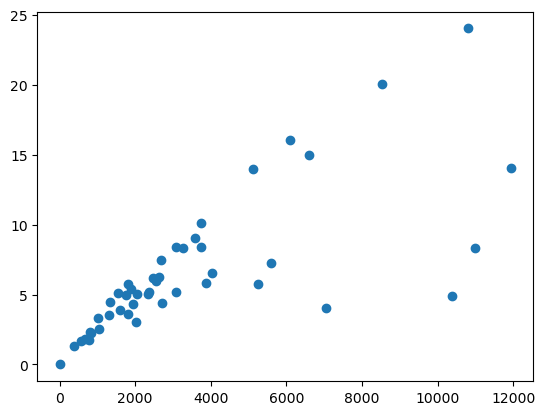

In [9]:
plt.scatter(list(df['Elapsed Time']), list(df['Distance']))

#### Section 2: Training, Cross-Validation, and Hyperparameter Tuning

In [11]:
# Assuming X is Elapsed Time and y is Distance
X = df[['Elapsed Time']]
y = df['Distance']

# Split the data into training, validation, and test sets (60-20-20 split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize the linear regression model
lr_model = LinearRegression()

# Fit the model on training data
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

In [14]:
# Calculate the cross validation score (using K-Fold cross validation)
cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='r2')
mean_cv_score = np.mean(cv_scores)
print(mean_cv_score)

-0.3721782600208785


In [27]:
# Define a range of degrees for polynomial regression
degrees = [1, 2, 3, 4]

best_degree = None
best_f1_score = -1

for degree in degrees:
    # Transform features to polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    
    # Split the data again with polynomial features
    X_train_poly, X_temp_poly, y_train_poly, y_temp_poly = train_test_split(X_poly, y, test_size=0.4, random_state=42)
    X_val_poly, X_test_poly, y_val_poly, y_test_poly = train_test_split(X_temp_poly, y_temp_poly, test_size=0.5, random_state=42)
    
    # Initialize and fit the polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train_poly)
    
    # Predict on validation set
    y_val_pred_poly = poly_model.predict(X_val_poly)
    
    # Convert predictions to binary classes (assuming a threshold)
    threshold = 5  # Adjust as needed
    y_val_pred_binary = (y_val_pred_poly > threshold).astype(int)
    y_val_true_binary = (y_val_poly > threshold).astype(int)
    
    # Calculate F1-score
    f1 = f1_score(y_val_true_binary, y_val_pred_binary)
    
    # Check if this degree gives a better F1-score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_degree = degree

# Fit the best model on the entire dataset
best_poly = PolynomialFeatures(degree=best_degree)
X_poly = best_poly.fit_transform(X)
lr_poly_model = LinearRegression()
lr_poly_model.fit(X_poly, y)
print(f"Best Degree: {best_degree}")

Best Degree: 1


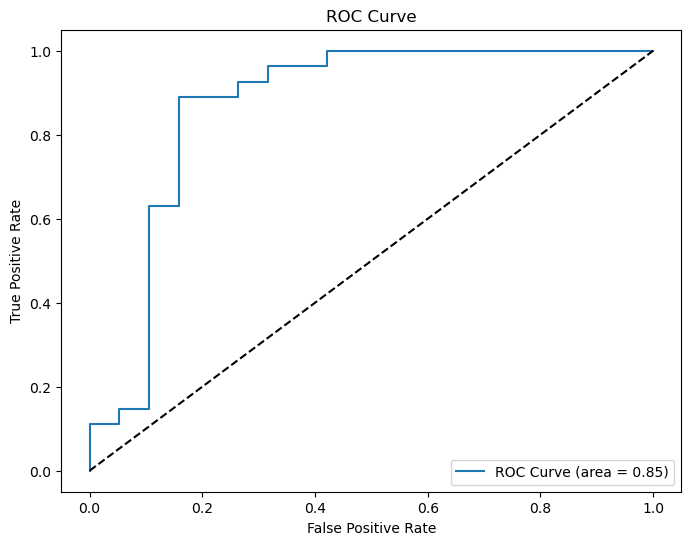

Cross Validation Score (R2): -0.37217826002087834
F1 Score: 0.8679245283018868
ROC-AUC Score: 0.8469785575048733


In [19]:
# Calculate cross validation score
cv_scores_best = cross_val_score(lr_poly_model, X_poly, y, cv=5, scoring='r2')
mean_cv_score_best = np.mean(cv_scores_best)

# Predict on the entire dataset
y_pred_poly = lr_poly_model.predict(X_poly)

# Calculate F1-score
threshold = 5  # Adjust as needed
y_pred_binary = (y_pred_poly > threshold).astype(int)
y_true_binary = (y > threshold).astype(int)
f1_best = f1_score(y_true_binary, y_pred_binary)

# Calculate ROC-AUC score and plot ROC curve
roc_auc = roc_auc_score(y_true_binary, y_pred_binary)
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_poly)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"Cross Validation Score (R2): {mean_cv_score_best}")
print(f"F1 Score: {f1_best}")
print(f"ROC-AUC Score: {roc_auc}")

/Users/ChristopherFok/anaconda3/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


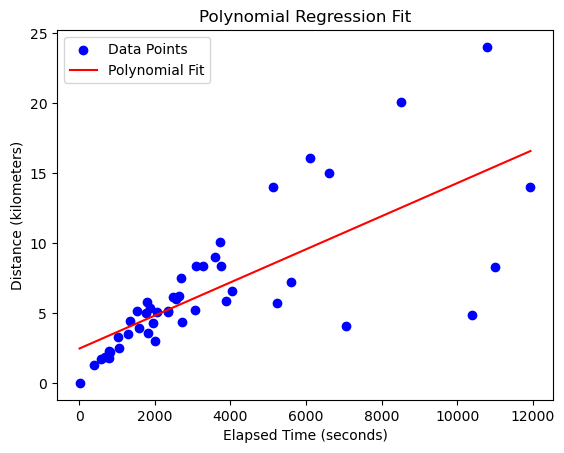

In [25]:
import matplotlib.pyplot as plt


# Generate a range of x values for plotting
x_values = np.linspace(min(X.values), max(X.values), 100)[:, np.newaxis]
x_values = x_values.reshape(-1, 1)
x_values_poly = best_poly.transform(x_values)

# Predict the corresponding y values using the polynomial regression model
y_values_poly = lr_poly_model.predict(x_values_poly)

# Plot the original data points
plt.scatter(X, y, color='blue', label='Data Points')

# Plot the best polynomial fit
plt.plot(x_values, y_values_poly, color='red', label='Polynomial Fit')

# Add labels and title
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Distance (kilometers)')
plt.title('Polynomial Regression Fit')

# Add legend
plt.legend()

# Show the plot
plt.show()